# Denoising Diffusion Implicit Models (DDIM) on MNIST Dataset

In this notebook, we will explore the DDIM (Denoising Diffusion Implicit Models) approach, which allows for faster sampling compared to DDPM. We will:

1. Load the pre-trained DDPM model from the previous notebook
2. Use our modular implementation of diffusion models from the `src` folder
3. Compare the sampling time between DDPM and DDIM with different numbers of steps
4. Demonstrate the encoding and decoding process in DDIM

DDIM uses the same noise prediction network as DDPM but employs a deterministic sampling process that allows for much fewer sampling steps while maintaining quality.

In [1]:
import torch
import matplotlib.pyplot as plt
import os
import time
import numpy as np
import sys

# Add the src directory to Python path
sys.path.append(os.path.abspath('./'))

# Import our modules
from src.model import SimpleUnet
from src.data import get_mnist_dataset
from src.scheduler import linear_beta_schedule
from src.diffusion import DiffusionProcess, DDIM
from src.utils import plot_images, visualize_sampling_results, run_sampling_experiment, encode_decode_experiment, visualize_denoising_process

# Set device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Get the dataset
_, test_dataset = get_mnist_dataset(root='./data')

Using device: mps


## Load the Pre-trained DDPM Model

First, we need to load the model architecture and the pre-trained weights from the previous notebook.

In [2]:
# Load the pre-trained model
model = SimpleUnet(in_channels=1).to(device)
model_path = os.path.join('models', 'diffusion_model.pth')

try:
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print("Pre-trained model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")

Pre-trained model loaded successfully!


/var/folders/np/qz5mqdbj5fl9khbxwqpf9q340000gn/T/ipykernel_68633/2965819302.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, 

## Initialize Diffusion Models

Now, we'll initialize both the standard DiffusionProcess and the DDIM (Denoising Diffusion Implicit Model) using our modular implementation from the `src` folder. 

The DDIM class provides:

1. Faster sampling at a subsequence of timesteps
2. Controllable stochasticity (η parameter)
3. Encoding of real images into latent representations and decoding them back

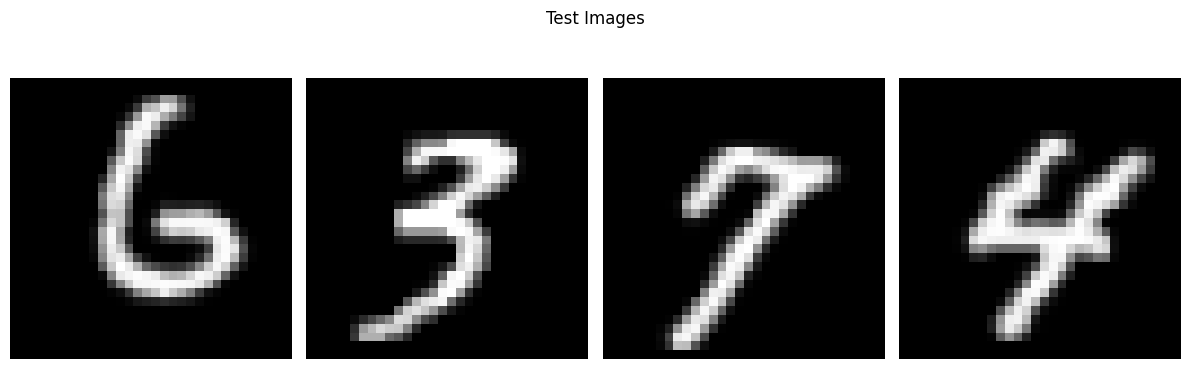

In [3]:
# Initialize variance schedule
timesteps = 1000
beta_schedule_tensor = linear_beta_schedule(timesteps).to(device)

# Create diffusion model instances
ddpm_model = DiffusionProcess(beta_schedule_tensor)
ddim_model = DDIM(beta_schedule_tensor)

# Get some test images
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True)
test_images = next(iter(test_loader))[0].to(device)

# Display some test images
plot_images(test_images, title="Test Images")

## Comparing DDPM and DDIM

Now, let's compare the DDPM and DDIM sampling processes in terms of:

1. Sampling time
2. Sample quality

We'll generate samples using DDPM and DDIM with various numbers of steps and measure the time it takes.

In [4]:
# Run the sampling experiment to compare DDPM and DDIM
print("Running sampling experiment...")
sampling_results = run_sampling_experiment(
    diffusion_model=ddim_model,
    model=model,
    n_samples=4,
    img_size=(1, 32, 32),
    device=device,
    timesteps=timesteps,
    steps_list=[50]
)

Running sampling experiment...


DDPM Sampling: 1000it [00:11, 87.41it/s]
DDPM Sampling: 1000it [00:11, 87.41it/s]


DDPM (1000 steps) sampling time: 11.45s


DDIM Sampling: 100%|██████████| 50/50 [00:00<00:00, 112.22it/s]


DDIM (η=0, 51 steps) sampling time: 0.45s


DDIM Sampling: 100%|██████████| 50/50 [00:00<00:00, 120.75it/s]

DDIM (η=1, 51 steps) sampling time: 0.42s


## Visualizing the Generated Samples

Now, let's visualize the samples generated by DDPM and DDIM with different numbers of steps.

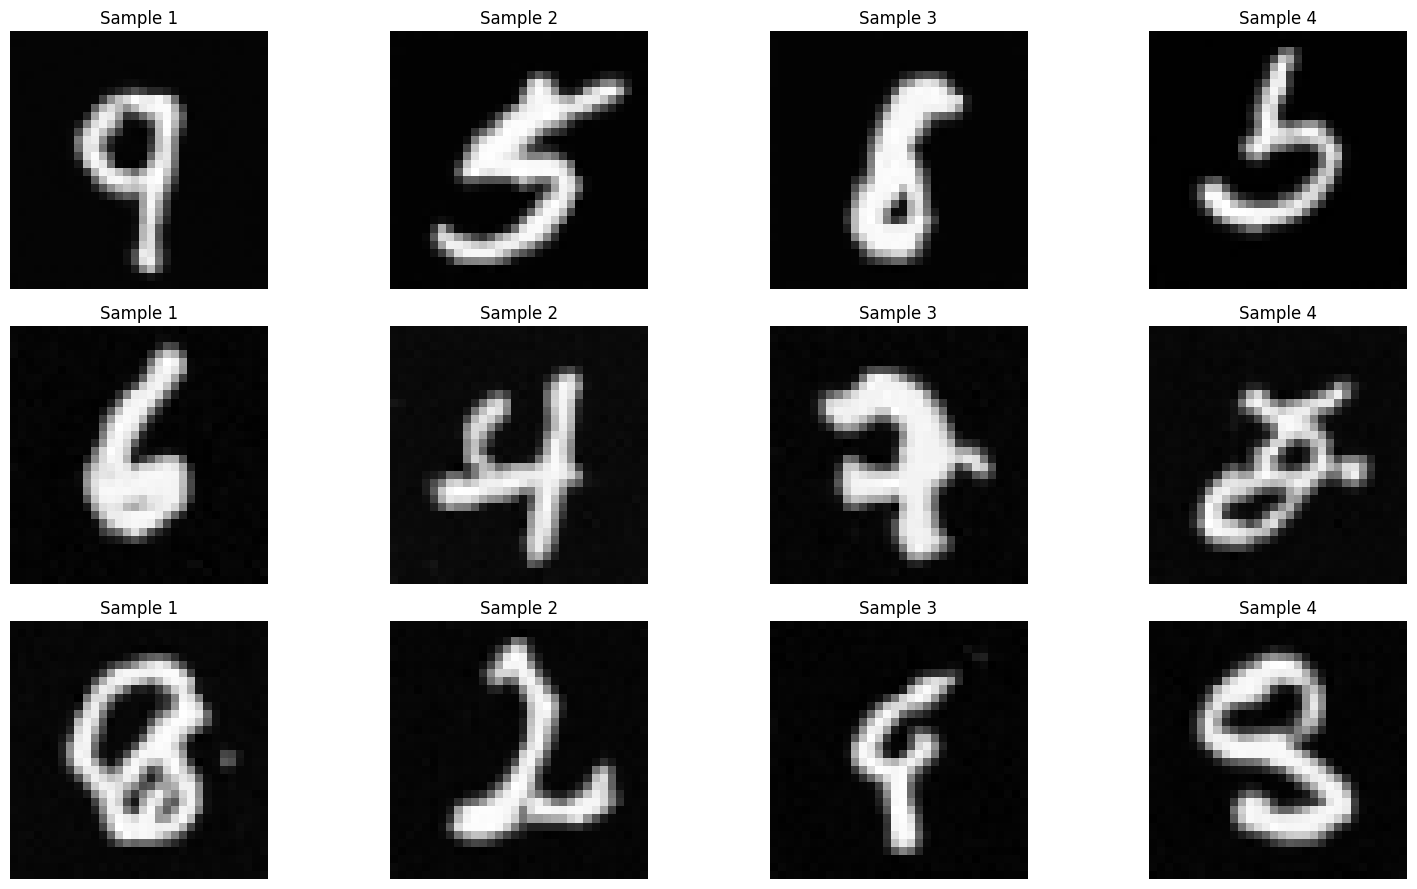

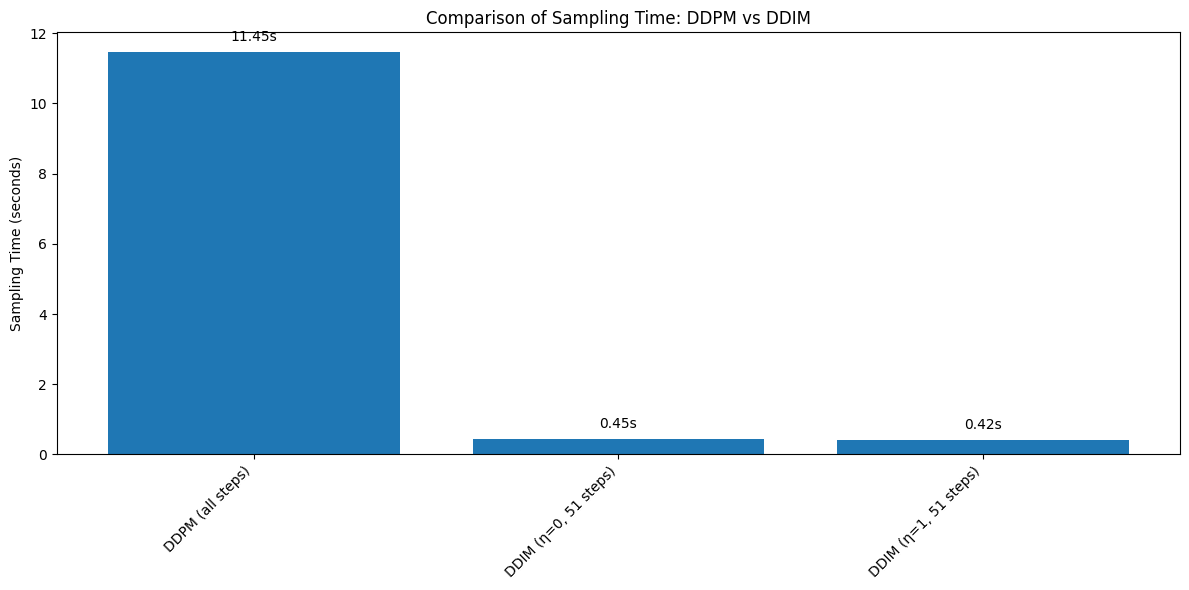

In [5]:
# Display the generated samples and timing comparison
visualize_sampling_results(sampling_results)

## Demonstrating DDIM Encoding and Decoding

One unique feature of DDIM compared to DDPM is its ability to encode real images to the latent space and then decode them back. This is possible because the DDIM process is deterministic (with η=0) and therefore invertible.

Let's demonstrate this by encoding some real MNIST images to latent space and then decoding them back.

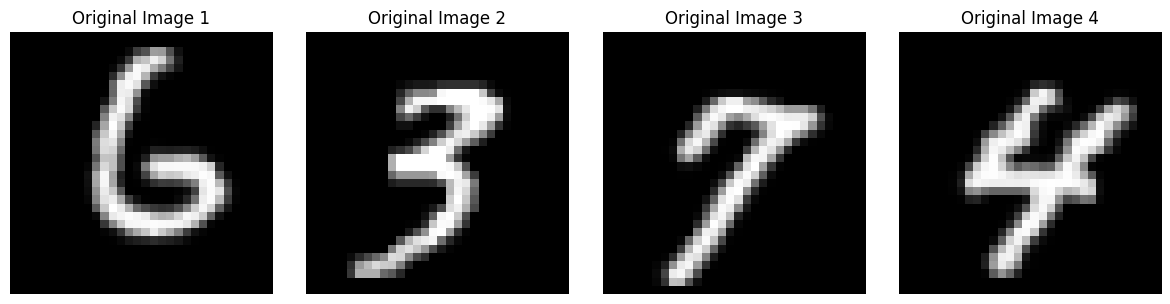


Encoding and decoding with all 1000 timesteps:
Encoding real images to latent space...


DDIM Encoding: 100%|██████████| 999/999 [00:08<00:00, 117.40it/s]



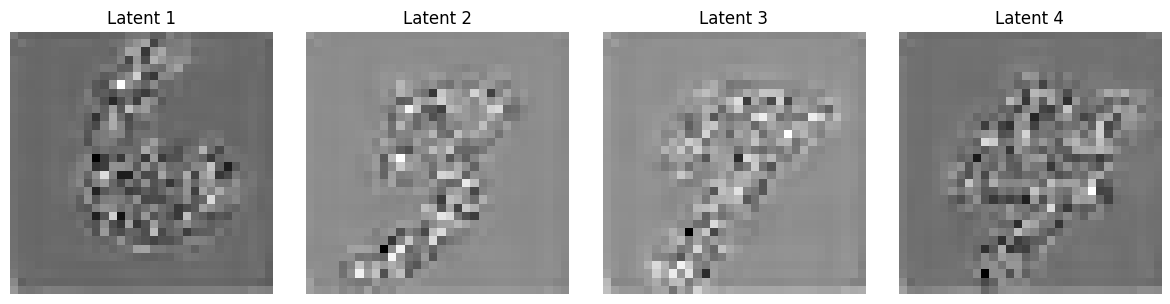

Decoding latents back to images...


DDIM Sampling: 100%|██████████| 999/999 [00:08<00:00, 118.18it/s]



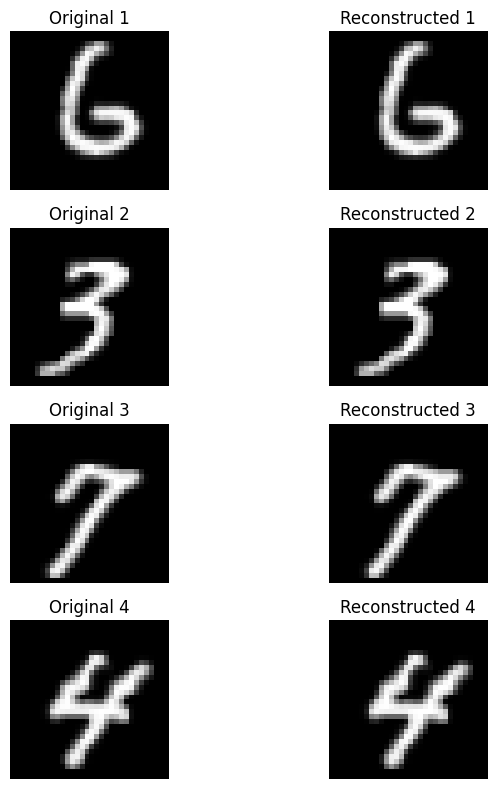


Encoding and decoding with 100 timesteps:
Encoding real images to latent space...


DDIM Encoding: 100%|██████████| 100/100 [00:00<00:00, 121.80it/s]



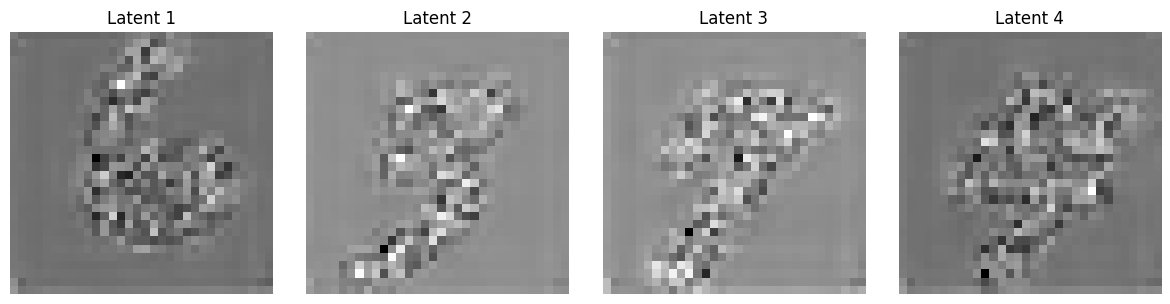

Decoding latents back to images...


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 117.99it/s]



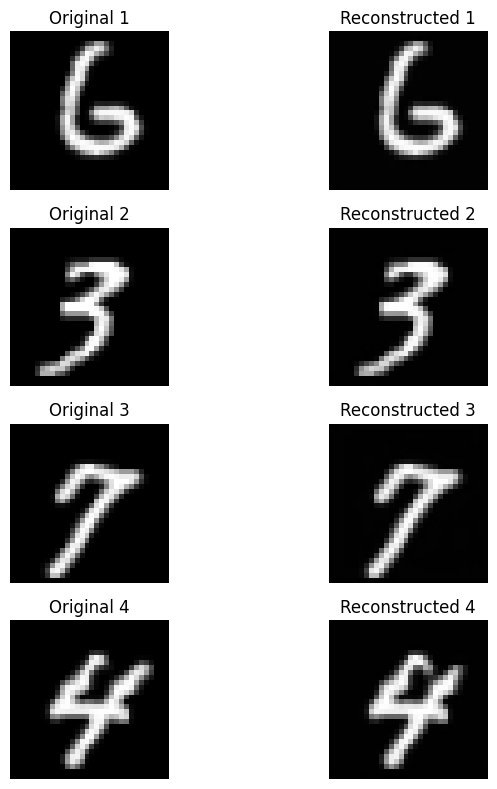


Encoding and decoding with 20 timesteps:
Encoding real images to latent space...


DDIM Encoding: 100%|██████████| 20/20 [00:00<00:00, 111.91it/s]



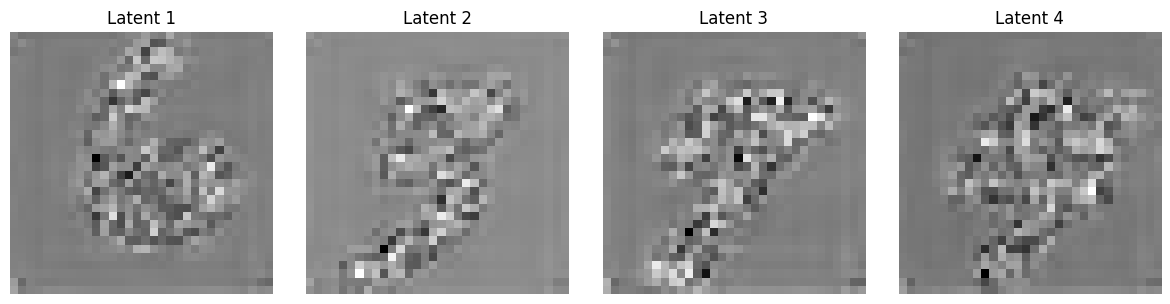

Decoding latents back to images...


DDIM Sampling: 100%|██████████| 20/20 [00:00<00:00, 105.96it/s]


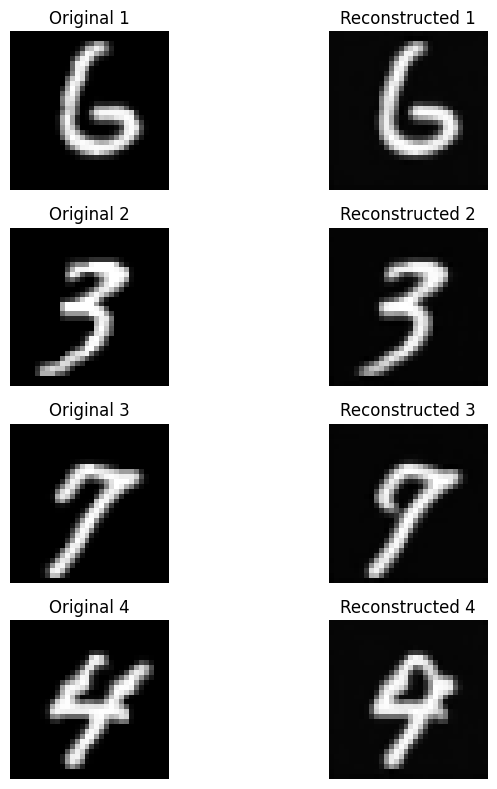

In [6]:
# Get some real images to encode
real_images = test_images[:4]

# Display the real images
plt.figure(figsize=(12, 3))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(real_images[i].squeeze().cpu(), cmap='gray')
    plt.title(f"Original Image {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Run the encoding/decoding experiment with different numbers of steps
print("\nEncoding and decoding with all 1000 timesteps:")
encoded_full, decoded_full = encode_decode_experiment(
    diffusion_model=ddim_model,
    model=model,
    images=real_images,
    device=device
)

print("\nEncoding and decoding with 100 timesteps:")
encoded_100, decoded_100 = encode_decode_experiment(
    diffusion_model=ddim_model,
    model=model,
    images=real_images,
    device=device,
    steps_subset=100,
    timesteps=timesteps
)

print("\nEncoding and decoding with 20 timesteps:")
encoded_20, decoded_20 = encode_decode_experiment(
    diffusion_model=ddim_model,
    model=model,
    images=real_images,
    device=device,
    steps_subset=20,
    timesteps=timesteps
)

## Visualizing the Denoising Process: DDPM vs DDIM

Now let's visualize how the denoising process differs between DDPM and DDIM. We'll use our improved visualization function that:

1. Uses DDIM with η=1 to simulate DDPM (which is mathematically equivalent)
2. Uses DDIM with η=0 for deterministic sampling (true DDIM)
3. Shows the last few steps of the denoising process to focus on how the images form
4. Includes clear row labels to distinguish between η=0 and η=1 sampling

The key difference is that DDIM allows us to skip many intermediate steps while maintaining high quality, while DDPM requires going through all steps sequentially. We'll demonstrate this by showing both methods with reduced sampling steps.

Generating DDPM (DDIM with η=1) images...


DDIM Sampling with η=1.0: 100%|██████████| 100/100 [00:01<00:00, 58.85it/s]


Generating deterministic DDIM (η=0) images...


DDIM Sampling with η=0.0: 100%|██████████| 100/100 [00:00<00:00, 112.57it/s]


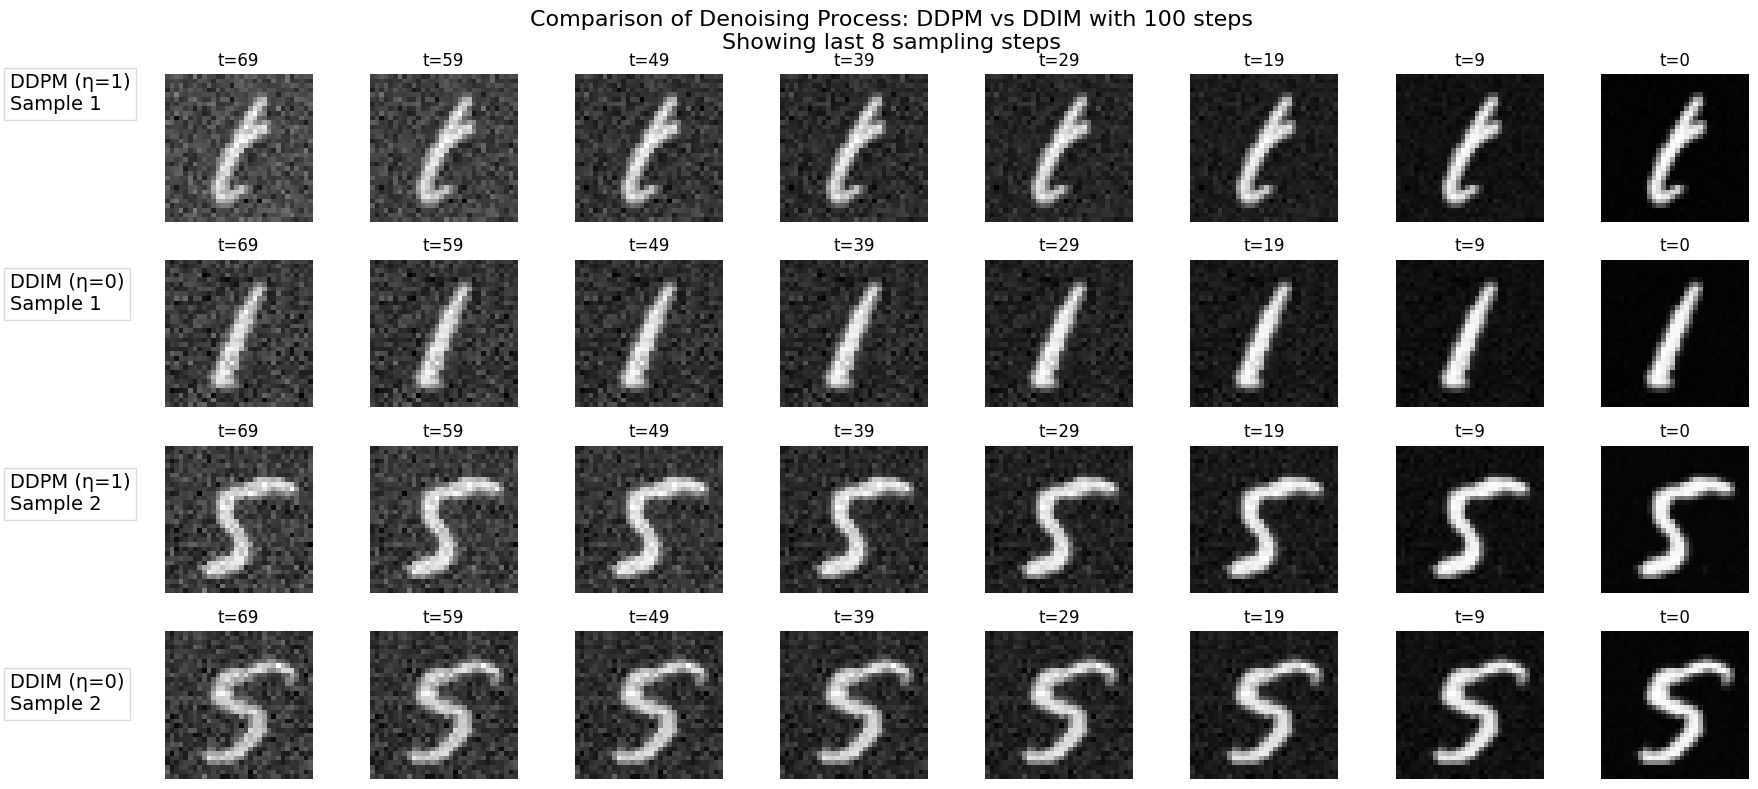

In [7]:
# First, let's visualize with 100 sampling steps (10% of the full 1000 steps)
# showing the last 8 steps of denoising for 2 samples
visualize_denoising_process(
    diffusion_model=ddim_model,
    model=model,
    device=device,
    n_samples=2,            # Generate 2 samples
    steps_to_show=8,        # Show the last 8 steps in the visualization
    sampling_steps=100,     # Use 100 sampling steps (10% of the full process)
    img_size=(1, 32, 32)    # MNIST image size
)

### Demonstrating Even Faster Sampling

Now, let's push DDIM even further by using only 20 sampling steps (2% of the original 1000 steps) and see if it can still produce good results. By showing the last 6 steps of both methods, we can clearly observe how DDIM maintains quality with fewer steps while DDPM (η=1) struggles to converge as quickly.

Generating DDPM (DDIM with η=1) images...


DDIM Sampling with η=1.0: 100%|██████████| 20/20 [00:00<00:00, 105.70it/s]


Generating deterministic DDIM (η=0) images...


DDIM Sampling with η=0.0: 100%|██████████| 20/20 [00:00<00:00, 109.08it/s]


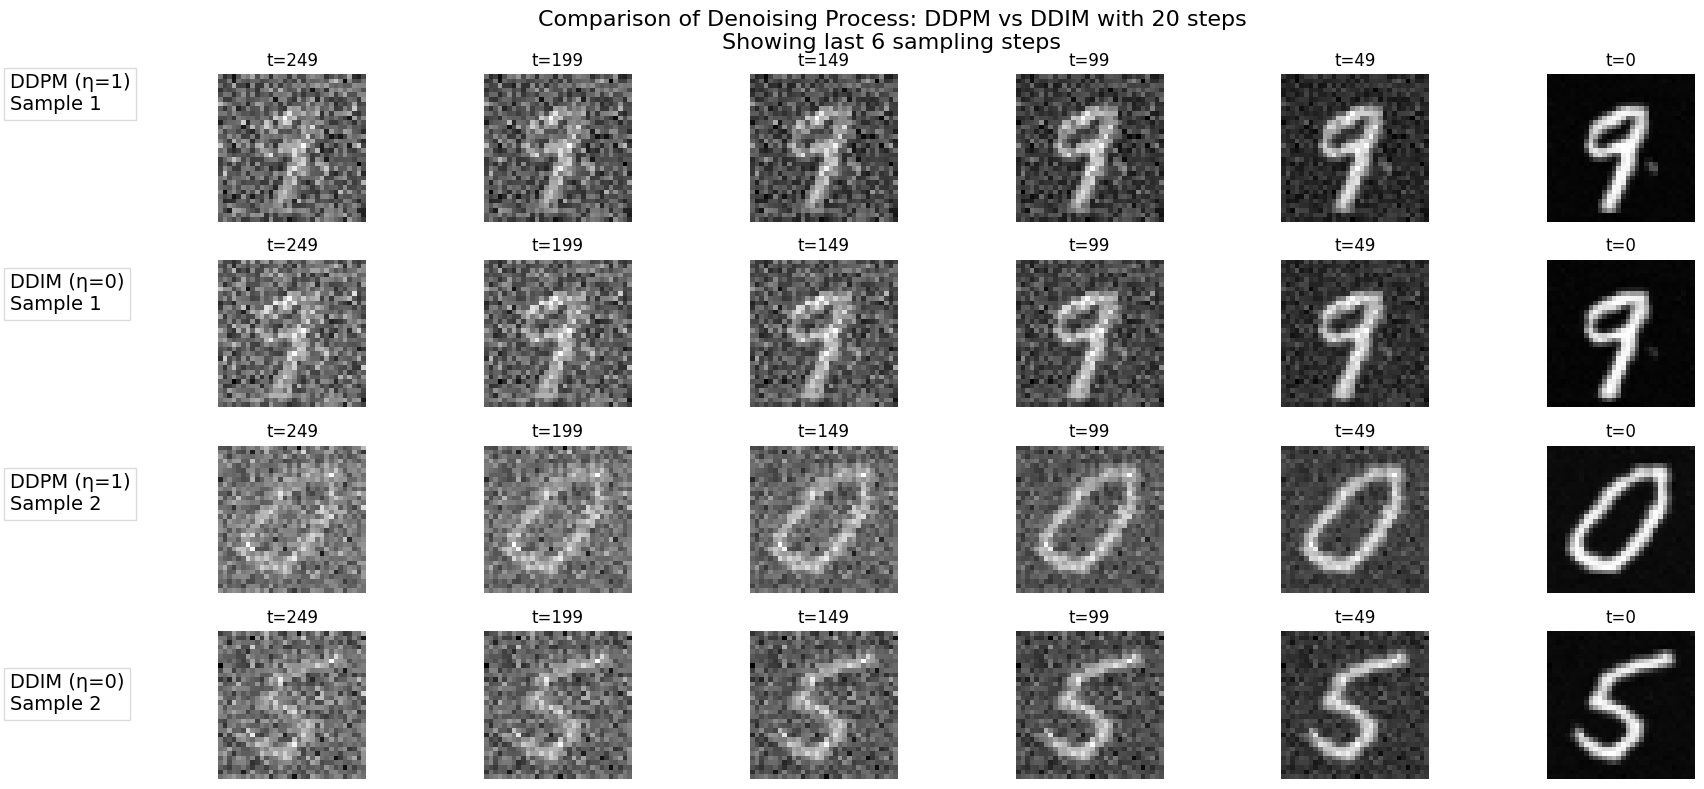

In [8]:
# Now let's try with just 20 sampling steps (2% of the full 1000 steps)
# This really highlights DDIM's ability to skip steps effectively
visualize_denoising_process(
    diffusion_model=ddim_model,
    model=model,
    device=device,
    n_samples=2,            # Generate 2 samples
    steps_to_show=6,        # Show the last 6 steps in the visualization
    sampling_steps=20,      # Use only 20 sampling steps (very accelerated)
    img_size=(1, 32, 32)    # MNIST image size
)

## Conclusion

In this notebook, we've explored DDIM sampling and compared it to the original DDPM approach. Here are the key takeaways:

1. **Sampling Efficiency**: DDIM can generate high-quality samples with far fewer sampling steps compared to DDPM. As we've seen in the visualizations, even with only 20 steps (vs 1000 in the original process), DDIM can produce good results.

2. **Deterministic vs Stochastic**: With η=0, DDIM is completely deterministic, while with η=1, it becomes equivalent to DDPM's stochastic sampling. When η=0, the same starting noise always produces the same output image.

3. **Visual Differences in the Final Steps**: By focusing on the last steps of the denoising process, we can observe that:
   - DDPM (η=1) shows more gradual, noisy transitions with stochastic elements visible between steps
   - DDIM (η=0) shows a more direct path to the final image with cleaner intermediate results
   - With very few steps (20), DDIM maintains coherence while DDPM struggles to converge smoothly

4. **Invertibility**: The deterministic nature of DDIM enables encoding real images to the latent space and then reconstructing them, which we demonstrated in the encoding/decoding experiment.

5. **Same Training Model**: DDIM uses the same noise prediction network as DDPM, which means we can apply DDIM to any pre-trained DDPM model without retraining.

6. **Parameter Control**: The η parameter allows for controlling the stochasticity of the sampling process, bridging between deterministic DDIM (η=0) and stochastic DDPM (η=1).

Overall, DDIM represents a significant advancement in diffusion models, allowing for much faster generation while maintaining or even improving sample quality. This is particularly important for practical applications where generation speed matters.